Developped by building up on https://github.com/OGGM/databases-links

In [1]:
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry as shpg


# imports for oggm
from oggm import utils, cfg

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 

2024-05-02 17:52:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-02 17:52:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-02 17:52:32: oggm.cfg: Multiprocessing: using all available processors (N=12)
2024-05-02 17:52:36: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-05-02 17:52:36: oggm.cfg: Multiprocessing switched ON after user settings.


In [3]:
def plot_glaciers_map_with_RGI(glacier_df, rgi_shapefile):
    f = plt.figure(figsize=(14, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # mark a known place to help us geo-locate ourselves 
    rgi_shapefile.geometry.plot(ax=ax)
    ax.plot(glacier_df.POINT_LON.values, glacier_df.POINT_LAT.values, 'bo', markersize=4, transform=ccrs.Geodetic())
    
    ax.add_feature(cartopy.feature.COASTLINE, edgecolor='gray');
    ax.set_extent([-180, 180, -90, 90])
    return f, ax

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between one point 
    
    on the earth and an array of points (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r


def find_RGI(row, rgi_df):
    lon, lat = row.POINT_LON, row.POINT_LAT
    gp = shpg.Point(lon, lat)

    # check if glacier is in the same rgi outline as the preceding glacier
    if 'RGI_ID' in row and pd.notnull(row['RGI_ID']):
        last_RGI_ID_assigend=row['RGI_ID']
        s=rgi_df[rgi_df['RGIId']==last_RGI_ID_assigend]
        if  len(s.index)!=0 and s.iloc[0].geometry.buffer(0).contains(gp):
            return last_RGI_ID_assigend
        else: 
            return find_glacierRGI_in_region(gp, lon, lat, rgi_df)    
    else:  
        return find_glacierRGI_in_region(gp, lon, lat, rgi_df) 


def find_RGI_IDs_for_measurements(glacier_df, regions=[]):
    found = []
    gdt_ids = []
    if not regions:
        regions = set()
        for n in set(glacier_df.RGI_Region.values):
            regions.add(str(n).zfill(2)) #set of regions we have to search through to find the glaciers in glacier_df
         
    for region in regions:
        print('region searched through atm: ', region)
        #get the rgi file for the region
        rgi_shp = utils.get_rgi_region_file(region, version='62') # region files are saved in the oggm directory
        rgi_df = gpd.read_file(rgi_shp)
        # subset of glaciers in the region that we want to find the rgi_id for
        glacier_sub = glacier_df.loc[glacier_df.RGI_Region == int(region)]
        # go through subset
        
        for i, row in glacier_sub.iterrows():
            gdt_ids.append(i)
            lon, lat = row.POINT_LON, row.POINT_LAT
            gp = shpg.Point(lon, lat)

            # check if glacier is in the same rgi outline as the preceding glacier
            if found: 
                last_RGI_ID_assigend=found[-1]
                s=rgi_df[rgi_df['RGIId']==last_RGI_ID_assigend]
                if  len(s.index)!=0 and s.iloc[0].geometry.buffer(0).contains(gp):
                    found.append(last_RGI_ID_assigend)
                else: found.append(find_glacierRGI_in_region(gp, lon, lat, rgi_df))    
            else:  
                found.append(find_glacierRGI_in_region(gp, lon, lat, rgi_df))      

    found_s = pd.Series(found, index=gdt_ids)
    glacier_df['RGI_ID'] = found_s
    return glacier_df

def find_glacierRGI_in_region(glacierpoint, lon, lat, rgi_df):
    #calculate distance to all glaciers in region (would be better if it was subregion only)
    rgi_df['DIST'] = haversine(lon, lat, rgi_df.CenLon.values, rgi_df.CenLat.values)
    sortrgi = rgi_df.sort_values(by='DIST')
    
    for potential_glacier_id in range(11):
        s = sortrgi.iloc[potential_glacier_id]
        if s.geometry.buffer(0).contains(glacierpoint): #is position of glacier within outline of RGI Glacier?
            return sortrgi.iloc[potential_glacier_id].RGIId
            
    # give up and set None if glacier not wihtin the outlines of the 10 nearest glaciers
    return None
    

In [5]:

cfg.PATHS['working_dir']  = 'links' 


gtd_TTT = pd.read_csv('glathida-3.1.0/data/TTT.csv', header=0, encoding='iso8859_15', sep=',', low_memory=False) # read the GlaThiDa data
gtd_TTT['GlaThiDa_ID']=gtd_TTT.GlaThiDa_ID.values.astype(int)



Take a quick look at all the files we just opened

In [6]:
gtd_TTT.head()

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
0,33,US,EASTON,19929999.0,NaN,1,48.767380,-121.819644,2962.0,0,NaN,NaN,NaN
1,33,US,EASTON,19929999.0,NaN,2,48.764904,-121.821909,2813.0,29,NaN,NaN,NaN
2,33,US,EASTON,19929999.0,NaN,3,48.761662,-121.825264,2598.0,41,NaN,NaN,NaN
3,33,US,EASTON,19929999.0,NaN,4,48.757063,-121.829107,2383.0,71,NaN,NaN,NaN
4,33,US,EASTON,19929999.0,NaN,5,48.753715,-121.832006,2284.0,82,NaN,NaN,NaN


Prepare GlaThiDa measurements for linking, kicking out measurements we do not need to have fewer operations to do: Only take points with measurements from Svalbard and Jan Mayen

In [14]:
prepro_gtd = gtd_TTT[gtd_TTT.POLITICAL_UNIT=='SJ'] # only svalbard and jan mayen
prepro_gtd.dropna(subset=['POINT_LAT', 'POINT_LON'], inplace=True) # only measurements where coordinates are known


/tmp/ipykernel_11863/2963181567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepro_gtd.dropna(subset=['POINT_LAT', 'POINT_LON'], inplace=True) # only measurements where coordinates are known


Plot map of glaciers' positions

(<Figure size 1400x800 with 1 Axes>, <GeoAxesSubplot:>)

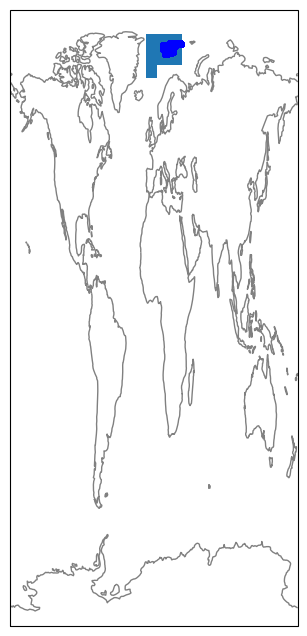

In [15]:
rgi_shp_path = utils.get_rgi_region_file('07', version='62') # region files are saved in the oggm directory
rgi_shapefile = gpd.read_file(rgi_shp_path)
plot_glaciers_map_with_RGI(prepro_gtd, rgi_shapefile)

In [19]:
print('number of measurements:', prepro_gtd.size)
prepro_gtd.head()


number of measurements: 12563304


,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
52401,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,1,78.142067,18.088784,91.0,48,3.0,NaN,NaN
52402,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,2,78.142114,18.089258,91.0,49,4.0,NaN,NaN
52403,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,3,78.142146,18.089611,88.0,48,4.0,NaN,NaN
52404,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,4,78.142253,18.089667,89.0,49,4.0,NaN,NaN
52405,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,5,78.142367,18.089620,84.0,50,4.0,NaN,NaN


In [20]:
prepro_gtd['RGI_Region']=7 #set region to 7 because we just kicked out all the other measurements
prepro_gtd_with_RGI_reg7 = find_RGI_IDs_for_measurements(prepro_gtd, ['07']) #find the RGI_IDs for the glaciers in the dataframe

/tmp/ipykernel_11863/3526022666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepro_gtd['RGI_Region']=7 #set region to 7 because we just kicked out all the other measurements


region searched through atm:  07


/tmp/ipykernel_11863/3471926805.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glacier_df['RGI_ID'] = found_s


Check on which glaciers the measurements are that could not be conneted to RGI and how many are there? 

In [21]:
grouped = prepro_gtd_with_RGI_reg7[prepro_gtd_with_RGI_reg7.RGI_ID.isna()].groupby('GLACIER_NAME')
print('Glacier name  ', 'missing measurements  ', 'total num measurements  ')
for i, glacier in grouped:
    #print(i, len(glacier))
    all = prepro_gtd_with_RGI_reg7[prepro_gtd_with_RGI_reg7.GLACIER_NAME==i]
    print(i, len(glacier), len(all))

Glacier name   missing measurements   total num measurements  
ALDEGONDABREEN 7 2018
ARIEBREEN 1 436
AUSTRE DAHLFONNA 35 3512
BAALSRUDBREEN 14 2731
CHYDENIUSBREEN 38 149
ELFENBEINBREEN 15 6835
FRIDTJOVBREEN 248 23943
INFANTFONNA 98 4885
KONGSBREEN 17 103096
KONGSVEGEN 3 68203
KRONEBREEN 123 47277
LIESTOELBREEN 29 618
MONACOBREEN 48 1241
NATHORSTBREEN 21 46
NEGRIBREEN 127 1373
OSLOBREEN 204 1503
PASSFJELLBREEN E 14 4479
PASSFJELLBREEN W 111 2908
PAULABREEN 1 452
PENCKBREEN 17 46
RAUDFJORDBREEN 56 85
SVEABREEN 146 306
TUNGEBREEN 13 3304
VESTRE DAHLFONNA 1 3472
VETERANEN 141 1630


In [22]:
print(prepro_gtd_with_RGI_reg7.size)
prepro_gtd_with_RGI_reg7_without_nans = prepro_gtd_with_RGI_reg7.dropna(subset=['RGI_ID']) #dropping all the measurements that couldnt be assigned to a glacier
print(prepro_gtd_with_RGI_reg7_without_nans.size)

14496120
14473200


In [24]:
prepro_gtd_with_RGI_reg7_without_nans.head()

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS,RGI_Region,RGI_ID
52401,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,1,78.142067,18.088784,91.0,48,3.0,NaN,NaN,7,RGI60-07.00428
52402,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,2,78.142114,18.089258,91.0,49,4.0,NaN,NaN,7,RGI60-07.00428
52403,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,3,78.142146,18.089611,88.0,48,4.0,NaN,NaN,7,RGI60-07.00428
52404,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,4,78.142253,18.089667,89.0,49,4.0,NaN,NaN,7,RGI60-07.00428
52405,2075,SJ,ELFENBEINBREEN,20140406.0,NaN,5,78.142367,18.089620,84.0,50,4.0,NaN,NaN,7,RGI60-07.00428


In [28]:
len(prepro_gtd_with_RGI_reg7_without_nans.RGI_ID.unique())


207

We got measurements on 207 glaciers, now how are the measurements distributed among those glaciers?

<AxesSubplot:>

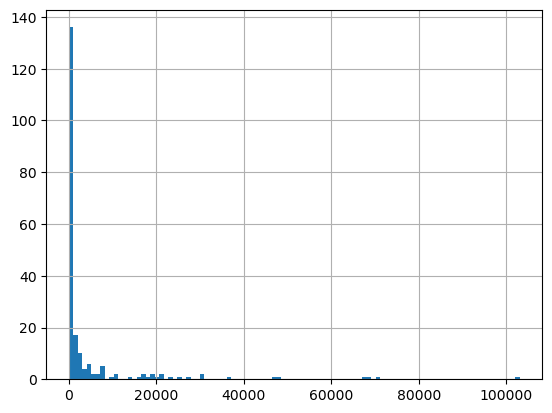

In [29]:

prepro_gtd_with_RGI_reg7_without_nans.RGI_ID.value_counts().hist(bins=100)

In [30]:
prepro_gtd_with_RGI_reg7_without_nans.RGI_ID.describe()

count             964880
unique               207
top       RGI60-07.01482
freq              103078
Name: RGI_ID, dtype: object

Save the dataframe of measurements attributed to RGI IDs to csv. 

In [81]:
prepro_gtd_with_RGI_reg7_without_nans.to_csv('TTT_with_RGI07_IDs_Svalbardonly.csv')